# Exact GP Regression on Classification Labels

For dataset size < 10,000, ExactGP works fine.

"In GPyTorch, Exact GP inference is still our preferred approach to large regression datasets. By coupling GPU acceleration with BlackBox Matrix-Matrix Inference and LancZos Variance Estimates (LOVE), GPyTorch can perform inference on datasets with over 1,000,000 data points while making very few approximations."
--[GPyTorch docs](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/index.html)

Paper: https://proceedings.neurips.cc/paper_files/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf


In [ ]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE


# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

imblearn version:  0.11.0


In [ ]:
# confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Get training data
data_path = "/p/lustre2/fan4/NEK_data/NEK2/scaled_descriptors/"

binding_df = pd.read_csv(data_path+"NEK2_1_uM_min_50_pct_binding_with_moe_descriptors.csv")
print(binding_df.shape)
moe_columns = binding_df.columns[3:]
moe_columns

(1408, 309)


Index(['ASA+_per_atom', 'ASA-', 'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom',
       'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3',
       'BCUT_SLOGP_0_per_atom',
       ...
       'vsurf_Wp2_per_atom', 'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5',
       'vsurf_Wp6', 'vsurf_Wp7', 'vsurf_Wp8', 'weinerPath',
       'weinerPol_per_atom', 'zagreb_per_atom'],
      dtype='object', length=306)

In [ ]:
inhibition_df = pd.read_csv(data_path+"NEK2_1_uM_min_50_pct_inhibition_with_moe_descriptors.csv")
inhibition_df

,compound_id,base_rdkit_smiles,active,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,kdb_819,O=C1CCCN1Cc1ccc2c(c1)[nH]c(=O)c1cccn12,1,8.151331,200.64983,9.752343,143.01337,13.724937,-2.506378,-0.666812,...,10.277778,82.375,16.750,7.000,1.750,0.000,0.000,926,0.916667,3.277778
1,kdb_952,O=C1NCCc2[nH]c(-c3ccncc3)cc21,0,10.828989,121.34690,10.714393,124.44099,15.323319,-2.513579,-0.604552,...,13.648148,104.000,29.125,11.500,3.375,0.000,0.000,426,0.851852,3.185185
2,kdb_704,CN(C)CC1CN(c2ccc3nc(-c4n[nH]c5ccc([N+](=O)[O-]...,0,7.934616,158.87631,7.420585,189.45982,10.865310,-2.743183,-0.533248,...,10.134091,163.375,31.750,11.375,3.125,0.125,0.000,2905,0.909091,3.127273
3,kdb_1416,CC(C)Cc1nc(Nc2ccc(N3CCOCC3)c(Cl)c2)nc2[nH]ccc12,0,8.484605,202.84538,9.316943,162.70578,12.507252,-2.663910,-0.574060,...,10.022059,145.000,33.500,12.500,3.875,0.000,0.000,1989,0.803922,2.823529
4,kdb_3103,O=C([O-])c1ccc(Oc2nccc(-c3c(-c4ccc(F)cc4)ncn3C...,0,6.847276,246.11134,8.917394,130.18471,11.242121,-2.754876,-0.641494,...,9.799107,130.625,18.500,6.375,0.875,0.000,0.000,3565,0.964286,3.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,kdb_688,CC(C)(C)NC(=O)Nc1ccc2[nH]nc(-c3nc4ccc(N5CCC(N6...,0,7.971653,225.96501,7.949403,233.67830,10.984186,-2.864683,-0.493118,...,10.284091,281.250,86.000,38.375,16.500,5.625,2.125,5461,0.779221,2.753247
2040,kdb_3174,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,0,6.315649,292.53967,8.651390,138.96046,10.725427,-2.612002,-0.649000,...,9.535448,156.125,18.250,7.375,1.750,0.000,0.000,6177,0.850746,3.074627
2041,kdb_687,COCCOc1ccc2[nH]c(-c3n[nH]c4cc(F)ccc34)nc2c1,0,9.166876,204.00128,11.519772,117.64021,14.536188,-2.446193,-0.614782,...,12.205128,134.625,31.500,12.750,4.125,0.125,0.000,1454,0.923077,3.333333
2042,kdb_3568,COc1cc(OC)c(/C=C2\C(=O)Nc3ccccc32)c(OC)c1,0,8.273334,156.50420,9.431938,110.16006,12.185938,-2.321398,-0.554833,...,8.609375,75.875,17.000,6.000,1.500,0.000,0.000,1136,0.950000,3.000000


In [ ]:
# Obtain splits
split_path = "/p/lustre2/fan4/NEK_data/NEK2"
random_binding_df = pd.read_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_5_fold_cv_random_randomSplits.csv")
print(random_binding_df['fold'].unique())
print(random_binding_df['fold'].value_counts())
print(random_binding_df.columns)
random_binding_df.rename(columns={'cmpd_id': 'compound_id'}, inplace=True)
print(random_binding_df.columns)


[0 1 2 3 4]
fold
0    507
4    226
1    225
2    225
3    225
Name: count, dtype: int64
Index(['cmpd_id', 'subset', 'fold'], dtype='object')
Index(['compound_id', 'subset', 'fold'], dtype='object')


In [ ]:
# Generate a new 5-fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

random_binding_df = random_binding_df.drop(columns=['fold'])

for i, (_, v_ind) in enumerate(kf.split(random_binding_df)):
    random_binding_df.loc[random_binding_df.index[v_ind], 'fold'] = f"fold{i+1}"

random_binding_df['fold'].value_counts()


fold
fold1    282
fold3    282
fold2    282
fold4    281
fold5    281
Name: count, dtype: int64

In [ ]:
# Use the fold 0 as the test set, fold 1,2,3,4 as the train set
#test_random_binding_df = random_binding_df.loc[random_binding_df['fold'] == "0"]
#train_random_binding_df = random_binding_df.loc[random_binding_df['fold'] != "0"]
test_random_binding_df = random_binding_df.loc[random_binding_df['fold'] == "fold1"]
train_random_binding_df = random_binding_df.loc[random_binding_df['fold'] != "fold1"]
print(test_random_binding_df.shape)
print(train_random_binding_df.shape)

test_binding_moe_df = pd.merge(binding_df, test_random_binding_df, how="inner", on=["compound_id"])
test_x_df = test_binding_moe_df[moe_columns]
test_y_df = test_binding_moe_df['active']
print(test_x_df)
print(test_y_df.value_counts())

train_binding_moe_df = pd.merge(binding_df, train_random_binding_df, how="inner", on=["compound_id"])
train_x_df = train_binding_moe_df[moe_columns]
train_y_df = train_binding_moe_df['active']
print(train_x_df.shape)
print(train_y_df.value_counts())

(282, 3)
(1126, 3)
     ASA+_per_atom       ASA-  ASA_H_per_atom       ASA_P  ASA_per_atom  \
0         8.838330  181.76501       10.581412   94.610909     12.473630   
1         7.698597  316.91251        8.860716  232.077840     12.039864   
2         9.114582  225.49934       11.276764  143.336380     15.048775   
3         8.248036  215.08540       10.618368  115.099220     13.234260   
4         6.192729  313.64691        8.348100  223.601200     13.105573   
..             ...        ...             ...         ...           ...   
277       6.491342  233.13414        7.881495  149.453510     10.331552   
278       9.615436  177.48769       13.230006   47.363186     14.545649   
279       7.608602  208.33830        9.208908  129.923290     11.860404   
280       7.304606  311.21335        7.477071  302.590120     13.528873   
281       9.033107  139.98853        9.740264  106.827670     11.794643   

     BCUT_PEOE_0  BCUT_PEOE_1  BCUT_PEOE_2  BCUT_PEOE_3  \
0      -2.704441    -

In [ ]:
test_x_df.columns

NameError: name 'test_x_df' is not defined

In [ ]:
# Save to file
#uq_path = "/p/lustre2/fan4/NEK_data/NEK2/data4uq/"
uq_path = "/p/lustre2/fan4/myGPyTorch/classification_NEK2/data/"
#train_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_randomSplit_fold1_trainX.csv", index=False)
#train_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_randomSplit_fold1_trainY.csv", index=False)
#test_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_randomSplit_fold1_testX.csv", index=False)
#test_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_randomSplit_fold1_testY.csv", index=False)
train_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_trainX.csv", index=False)
train_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_trainY.csv", index=False)
test_x_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_testX.csv", index=False)
test_y_df.to_csv(uq_path+"/NEK2_1_uM_min_50_pct_binding_random_fold1_testY.csv", index=False)


In [ ]:
# PCA

x_df = pd.concat([train_x_df, test_x_df])

# PCA
# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df)

# Set the n_components=3
# 95% variance
principal=PCA(n_components=0.95)
principal.fit(Scaled_data)
pca_train_x_df=principal.transform(train_scaled_data)
pca_test_x_df=principal.transform(test_scaled_data)

print(pca_train_x_df.shape)
print(pca_test_x_df.shape)




(1126, 67)
(282, 67)


In [ ]:
# SMOTE

# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(pca_train_x_df, train_y_df)




/usr/WS2/fan4/gpytorch-venv/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/usr/WS2/fan4/gpytorch-venv/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [ ]:
# Transform data to PyTorch tensors

# PCA then SMOTE
train_x_temp = new_train_x_df.astype("long")
train_y_temp = new_train_y_df.to_numpy().astype("long")

# PCA
test_x_temp = pca_test_x_df.astype("long")


test_y_temp = test_y_df.to_numpy().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape)
print(train_y.shape)

torch.Size([2154, 67])
torch.Size([2154])


In [ ]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/300 - Loss: 6.991   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.210   lengthscale: 0.975   noise: 0.971
Iter 11/300 - Loss: 5.616   lengthscale: 1.321   noise: 1.275
Iter 16/300 - Loss: 5.178   lengthscale: 1.730   noise: 1.532
Iter 21/300 - Loss: 4.861   lengthscale: 2.193   noise: 1.671
Iter 26/300 - Loss: 4.634   lengthscale: 2.689   noise: 1.674
Iter 31/300 - Loss: 4.447   lengthscale: 3.189   noise: 1.556
Iter 36/300 - Loss: 4.277   lengthscale: 3.680   noise: 1.348
Iter 41/300 - Loss: 4.115   lengthscale: 4.153   noise: 1.088
Iter 46/300 - Loss: 3.968   lengthscale: 4.597   noise: 0.816
Iter 51/300 - Loss: 3.842   lengthscale: 4.995   noise: 0.570
Iter 56/300 - Loss: 3.751   lengthscale: 5.334   noise: 0.377
Iter 61/300 - Loss: 3.683   lengthscale: 5.612   noise: 0.243
Iter 66/300 - Loss: 3.621   lengthscale: 5.834   noise: 0.160
Iter 71/300 - Loss: 3.595   lengthscale: 6.005   noise: 0.111
Iter 76/300 - Loss: 3.579   lengthscale: 6.134   noise: 0.081
Iter 81/30

In [ ]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(train_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(train_x))

print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

/usr/WS2/fan4/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


(2, 2154)
tensor([0, 0, 0,  ..., 1, 1, 1])


Confusion matrix, without normalization
[[1076    1]
 [   0 1077]]


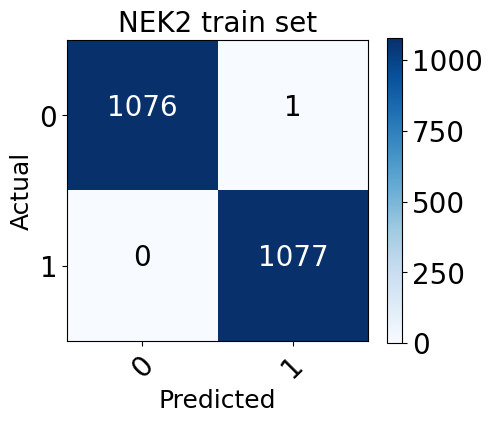

In [ ]:
train_prediction = model(train_x).loc.max(0)[1].numpy()
y_true = new_train_y_df.values
y_pred = train_prediction
train_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [ ]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(test_x))

print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

(2, 282)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(282,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Confusion matrix, without normalization
[[268   6]
 [  6   2]]


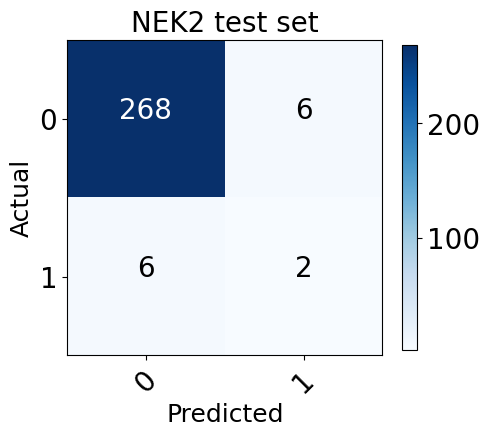

In [ ]:
y_true = test_y_df.values
y_pred = test_prediction
test_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [ ]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 1.9371,  2.1071,  2.4424,  2.5704,  2.5008,  1.7405,  2.5817,  1.4501,
          1.7467,  0.9649,  2.6552,  2.4597,  2.0502,  2.3053,  0.6534,  1.6003,
          2.3731,  2.2376,  2.5696,  1.8167,  2.4338,  2.0550,  2.2168,  2.3757,
          2.2055,  2.6098,  2.4363,  2.3490,  2.2081,  2.5695,  2.5075,  1.0381,
          2.7419,  1.0659,  2.4042,  2.0930,  2.4947,  1.7714,  2.2524,  2.6530,
          1.8475,  2.5809,  1.9501,  2.4751,  2.5405,  1.5068,  1.7427,  2.6232,
          0.2586,  0.0908,  1.4536,  2.5622,  2.2002,  2.5160,  2.5064,  2.6711,
          2.5774,  2.5727,  2.6611,  2.2008,  1.9526,  2.1944,  2.4912,  0.0705,
          1.7542,  2.4958,  2.5768,  2.5051,  2.1824,  2.2860,  1.2419,  1.6626,
          2.3053,  1.5273,  2.2451,  2.1257,  2.2316, -3.6972,  2.4305,  2.5191,
          2.5573,  2.5948, -0.3742,  1.9901,  1.7495,  2.2054,  2.0955,  1.0057,
          2.0098,  2.5267,  2.3449,  0.0768,  1.8954,  2.3783,  0.8746,  1.7462,
          2.2971,  2.3163,  

In [ ]:
observed_pred.mean.numpy()

array([[-0.7980644 , -0.624324  , -0.3217603 , -0.17422844, -0.2655434 ,
        -0.5308188 , -0.18534008, -1.2307005 , -0.37194324, -1.7034249 ,
        -0.03223406, -0.2421217 , -0.67969185, -0.45036602, -2.0437517 ,
        -0.3639282 , -0.3538792 , -0.260018  , -0.17149289, -0.7404324 ,
        -0.28693187, -0.56646514, -0.4668615 , -0.34148932, -0.5428665 ,
        -0.15293494, -0.27111602, -0.39820778, -0.53301376, -0.19483376,
        -0.24678408, -1.6156906 , -0.01570736, -1.5294477 , -0.36188376,
        -0.6548818 , -0.24884824, -0.9032768 , -0.499799  , -0.11118782,
        -0.8710316 , -0.18609607, -0.6748216 , -0.25396067, -0.22495799,
        -1.2339491 , -0.8581785 , -0.1386687 , -2.0143945 , -2.1307945 ,
        -1.0452682 , -0.20409608, -0.5443541 , -0.20707588, -0.25285193,
        -0.0801367 , -0.08134113, -0.19393839, -0.07223545, -0.24543439,
        -0.7259244 , -0.5072686 , -0.2604878 , -2.192941  , -0.85017157,
        -0.26402777, -0.1902231 , -0.24692735, -0.3

In [ ]:
print(observed_pred.variance.numpy().shape)
observed_pred.variance.numpy()

(2, 282)


array([[1.870287  , 1.8651507 , 1.9101675 , 1.8833063 , 1.913101  ,
        1.2897274 , 1.9140799 , 1.7967008 , 1.1221237 , 1.7799705 ,
        1.8055706 , 1.8249763 , 1.8630376 , 1.8983812 , 1.8186958 ,
        0.96453774, 1.859042  , 1.5595505 , 1.8784375 , 1.6347321 ,
        1.8505738 , 1.7180746 , 1.8005149 , 1.8457466 , 1.888378  ,
        1.908238  , 1.8325672 , 1.886779  , 1.87848   , 1.9104381 ,
        1.8965143 , 1.7607161 , 1.9011667 , 1.6839637 , 1.912872  ,
        1.8877119 , 1.8817087 , 1.7884649 , 1.8936617 , 1.9101504 ,
        1.8476431 , 1.9140799 , 1.722601  , 1.8619654 , 1.9119272 ,
        1.8779341 , 1.6911603 , 1.9069778 , 1.2916268 , 1.2338352 ,
        1.5610235 , 1.9131144 , 1.8832101 , 1.8538159 , 1.9033283 ,
        1.8923174 , 1.7671851 , 1.9136192 , 1.8678284 , 1.4960562 ,
        1.7936016 , 1.8247612 , 1.8929954 , 1.2807846 , 1.6956949 ,
        1.9041722 , 1.9140649 , 1.8934729 , 1.6500238 , 1.900761  ,
        1.7878345 , 1.61606   , 1.6635833 , 1.64

In [ ]:
print(pred_means.numpy())


[[-0.7980644  -0.624324   -0.3217603  -0.17422844 -0.2655434  -0.5308188
  -0.18534008 -1.2307005  -0.37194324 -1.7034249  -0.03223406 -0.2421217
  -0.67969185 -0.45036602 -2.0437517  -0.3639282  -0.3538792  -0.260018
  -0.17149289 -0.7404324  -0.28693187 -0.56646514 -0.4668615  -0.34148932
  -0.5428665  -0.15293494 -0.27111602 -0.39820778 -0.53301376 -0.19483376
  -0.24678408 -1.6156906  -0.01570736 -1.5294477  -0.36188376 -0.6548818
  -0.24884824 -0.9032768  -0.499799   -0.11118782 -0.8710316  -0.18609607
  -0.6748216  -0.25396067 -0.22495799 -1.2339491  -0.8581785  -0.1386687
  -2.0143945  -2.1307945  -1.0452682  -0.20409608 -0.5443541  -0.20707588
  -0.25285193 -0.0801367  -0.08134113 -0.19393839 -0.07223545 -0.24543439
  -0.7259244  -0.5072686  -0.2604878  -2.192941   -0.85017157 -0.26402777
  -0.1902231  -0.24692735 -0.38665307 -0.4713233  -1.4323359  -0.8798524
  -0.2743113  -1.0415167  -0.48250657 -0.3514681  -0.5266316  -5.5422034
  -0.3028226  -0.21454008 -0.20612776 -0.17219

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)



In [ ]:
# Draw samples from the posterior.
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities

tensor([[0.9653, 0.9730, 0.9808, 0.9889, 0.9869, 0.9865, 0.9935, 0.9089, 0.9957,
         0.8275, 0.9954, 0.9946, 0.9677, 0.9848, 0.7353, 0.9954, 0.9828, 0.9887,
         0.9902, 0.9702, 0.9791, 0.9680, 0.9863, 0.9895, 0.9682, 0.9920, 0.9877,
         0.9846, 0.9781, 0.9927, 0.9901, 0.8279, 0.9938, 0.8909, 0.9848, 0.9761,
         0.9845, 0.9600, 0.9837, 0.9938, 0.9591, 0.9867, 0.9714, 0.9929, 0.9923,
         0.9161, 0.9658, 0.9908, 0.6398, 0.7891, 0.9548, 0.9896, 0.9725, 0.9901,
         0.9930, 0.9910, 0.9896, 0.9892, 0.9938, 0.9911, 0.9759, 0.9804, 0.9891,
         0.6937, 0.9529, 0.9910, 0.9881, 0.9918, 0.9868, 0.9670, 0.8678, 0.9211,
         0.9862, 0.9441, 0.9856, 0.9939, 0.9744, 0.0362, 0.9829, 0.9921, 0.9944,
         0.9925, 0.4943, 0.9530, 0.9504, 0.9728, 0.9679, 0.8258, 0.9688, 0.9906,
         0.9883, 0.7867, 0.9529, 0.9872, 0.8425, 0.9657, 0.9909, 0.9792, 0.9912,
         0.9678, 0.9872, 0.9518, 0.9918, 0.9344, 0.9775, 0.9557, 0.9923, 0.9759,
         0.9728, 0.9900, 0.9

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

# Decision boundary
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)